# CNA analysis in Thor Tutorial

This notebook walks through running CNA analysis on a breast cancer (BC) sample, combining outputs across splits, and visualizing CNAs at gene and segment levels with predicted aneuploid/diploid labels.

## Overview
- Prepare per-split CopyKAT input files from an `AnnData` object
- Launch CopyKAT (R) per split and wait for completion
- Combine split outputs into prediction and CNA matrices
- Plot heatmaps (gene- and segment-level) with:
  - Alternating black/gray chromosome strip
  - Left bar showing aneuploid/diploid groups
  - Optional group name labels aligned to row blocks

## Requirements
- Thor. Please install the latest version: GitHub (commit: [b4b658d407b1dcaddf143e10cfe20926725c1dd7](https://github.com/GuangyuWangLab2021/Thor/tree/b4b658d407b1dcaddf143e10cfe20926725c1dd7))
- R with CopyKAT installed (used by the generated R scripts), following the instructions from [CopyKAT GitHub page](https://github.com/navinlabcode/copykat).
- Input `AnnData` with gene expression counts (optionally in a specific `layer`). The example file can be downloaded from [GitHub link](https://github.com/GuangyuWangLab2021/Thor/releases/download/data/ROI_BC.h5ad).

In [1]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

from thor.analy import (
    prepare_copykat,
    run_copykat,
    combine_copykat_results,
    combine_copykat_predictions,
    plot_cna_heatmap_with_pred,
    plot_segment_cna_heatmap_with_pred,
)

## Load Data and Configure Paths
- Set `adata_path` to your `.h5ad` file.
- Choose an output directory (will contain split folders and results).
- Set a short `sam_name` used as filename prefix.

In [2]:
sam_name = "BC"
adata_path = f"ROI_{sam_name}.h5ad"
out_dir = f"./copykat_{sam_name}"

adata = sc.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 921 × 2747
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'spot_barcodes', 'x', 'y', 'mean_gray', 'std_gray', 'entropy_img', 'mean_r', 'mean_g', 'mean_b', 'std_r', 'std_g', 'std_b', 'spot_heterogeneity_cv', 'node_weights', 'copy_variation', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'used_for_prediction', 'used_for_vae', 'used_for_reduced'
    uns: 'cell_image_props', 'copy_variation_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'recluster_normal_colors', 'snn', 'spatial', 'tumor_cluster_CNV_colors', 'tumor_normal_subtumor_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_vae', 'spatial'
    layers: 'fineST_10', 'fineST_10_sample1', 'fineST_20', 'fineST_20_sample1'

## Prepare CopyKAT Inputs
This creates per-split folders under `<out_dir>/split_data_forcopykat`, each with an R script and matrix for CopyKAT.

Notes:
- `cell_split` controls how many cells per split (adjust per dataset size). **If you have a relative small number of cells (<10,000), you may not need to split.**
- `genome` should match your reference (e.g., `hg20` or `hg19`).
- If your counts are in a particular `layer` of the AnnData, set it here; otherwise leave `layer=None`.

In [3]:
prepare_copykat(adata, out_dir, cell_split=200, sam_name=sam_name, genome="hg20", layer=None)

[09/16/25 12:08:26] INFO     Thor: Prepared folder                                                                                                    
                             /Users/pengzhizhang/thor_github_issues/copykat/copykat_BC/split_data_forcopykat/filtered_feature_bc_matrix_200_0         
                    INFO     Thor: Prepared folder                                                                                                    
                             /Users/pengzhizhang/thor_github_issues/copykat/copykat_BC/split_data_forcopykat/filtered_feature_bc_matrix_200_1         
                    INFO     Thor: Prepared folder                                                                                                    
                             /Users/pengzhizhang/thor_github_issues/copykat/copykat_BC/split_data_forcopykat/filtered_feature_bc_matrix_200_2         
                    INFO     Thor: Prepared folder                                            

## Run CopyKAT (R)
This launches the generated R scripts per split. Monitor logs in each split's `result/copykat.log`.
Re-run any failed jobs directly with `Rscript copykat.R` in the corresponding folder.

In [4]:
run_copykat(out_dir, batch_size=1)  # increase batch_size to parallelize if desired

                    INFO     Thor: CopyKAT package verified.                                                                                          
                    INFO     Thor: Found 5 split folders. Running in batches of 1.                                                                    
                    INFO     Thor: Starting batch 1: ['filtered_feature_bc_matrix_200_0']                                                             
                    INFO     Thor: Launching Rscript for filtered_feature_bc_matrix_200_0 (logging to                                                 
                             /Users/pengzhizhang/thor_github_issues/copykat/copykat_BC/split_data_forcopykat/filtered_feature_bc_matrix_200_0/copykat.
                             log)                                                                                                                     
[09/16/25 12:08:57] INFO     Thor: Finished filtered_feature_bc_matrix_200_0 successfully     

## Combine Outputs Across Splits
We merge: 
- Predictions into a two-column TSV `(cell_id, label)`
- Gene-level CNA matrices (with gene labels)
- Segment-level CNA matrices (windowed CNAs)

The `key_cols` argument is the number of shared leading columns that align rows across splits.
Use `key_cols=7` for the gene-by-cell files (which contain gene annotation columns), and `key_cols=3` for segment-level files.

In [5]:
base_dir = f"{out_dir}/split_data_forcopykat"
preds_path = combine_copykat_predictions(base_dir, sam_name, f"{out_dir}/pred_combined.tsv")

# Gene-level CNA (has gene columns; 7 key columns before cells)
cna_gene_path = combine_copykat_results(
    base_dir,
    f"{sam_name}_copykat_CNA_raw_results_gene_by_cell.txt",
    f"{out_dir}/{sam_name}_copykat_CNA_raw_results_gene_by_cell_combined.tsv",
    key_cols=7,
)

# Segment-level CNA (220kb windows; 3 key columns before cells)
cna_segment_path = combine_copykat_results(
    base_dir,
    f"{sam_name}_copykat_CNA_results.txt",
    f"{out_dir}/{sam_name}_copykat_CNA_results_combined.tsv",
    key_cols=3,
)

preds_path, cna_gene_path, cna_segment_path

('./copykat_BC/pred_combined.tsv',
 './copykat_BC/BC_copykat_CNA_raw_results_gene_by_cell_combined.tsv',
 './copykat_BC/BC_copykat_CNA_results_combined.tsv')

## Plot Gene-Level CNA Heatmap with Predictions
- Top strip: alternating black/gray by chromosome.
- Left strip: colors by predicted label (aneuploid/diploid).
- Optional left text labels centered on sorted contiguous groups.

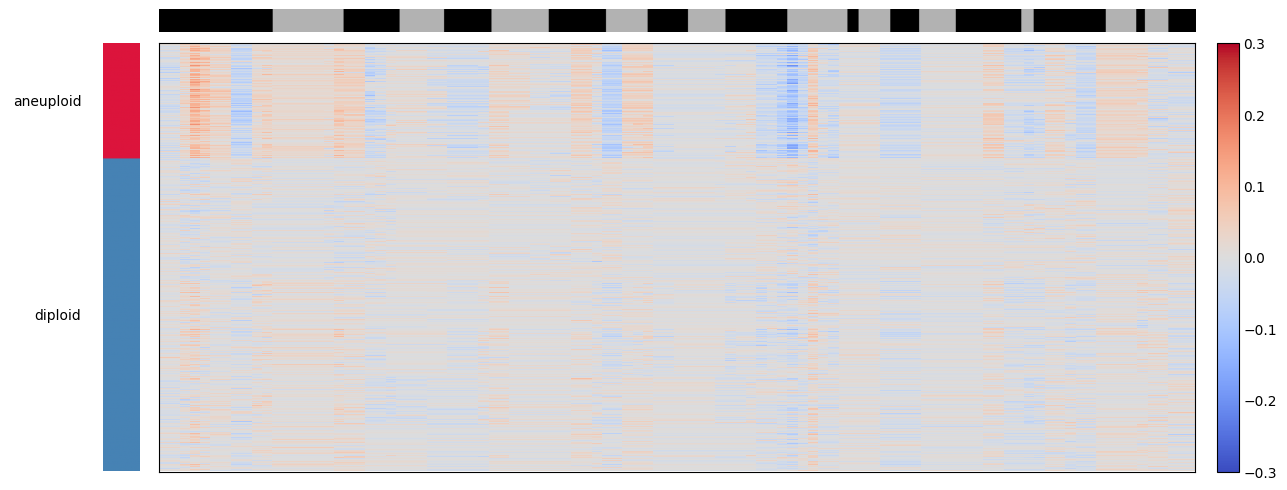

In [6]:
fig, axes = plot_cna_heatmap_with_pred(
    cna_gene_path,
    preds_path,
    vmin=-0.3, vmax=0.3, cmap="coolwarm", figsize=(16,6),
    show_group_labels=True, group_label_fontsize=10, group_label_color="black"
)
plt.show()

## Plot Segment-Level CNA Heatmap with Predictions
- Uses the segment/window-level matrix (columns: `chrom, chrompos, abspos, <cells>`)
- Handles barcode style mismatch (e.g., `TTG...-1-11` vs `TTG....1.11`) automatically
- Same alternating chromosome strip and group label options

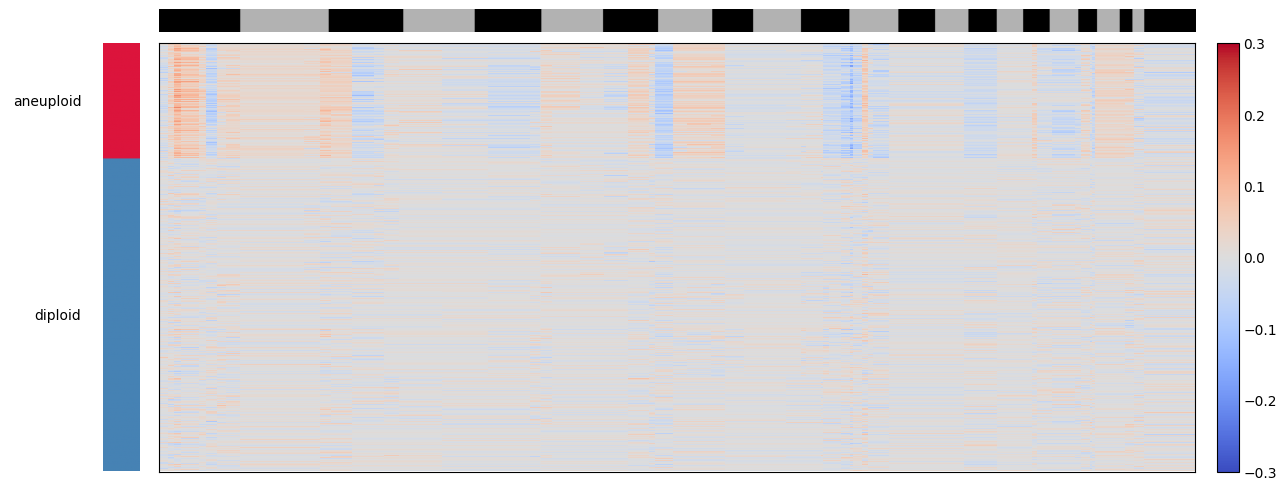

In [7]:
fig, axes = plot_segment_cna_heatmap_with_pred(
    cna_segment_path,
    preds_path,
    vmin=-0.3, vmax=0.3, cmap="coolwarm", figsize=(16,6),
    show_group_labels=True, group_label_fontsize=10, group_label_color="black"
)
plt.show()

## Plot Spatial Distributions of Aneuploid and Diploid Cells

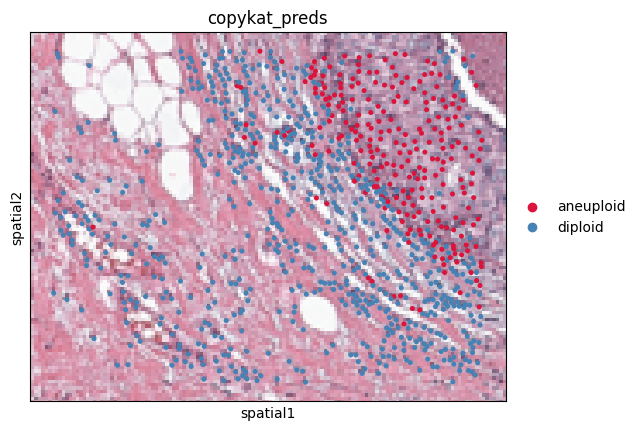

In [12]:
adata.obs["copykat_preds"] = pd.read_csv(preds_path, sep="\t", index_col=0)
adata.obs["copykat_preds"] = adata.obs["copykat_preds"].astype("category")
sc.pl.spatial(adata, color=["copykat_preds"], spot_size=20, palette={"aneuploid":"crimson","diploid":"steelblue"})

## Tips & Troubleshooting
- If any split fails, run its `Rscript` manually in the split folder; re-run combine steps afterward.
- Adjust `vmin/vmax` and `cmap` to change heatmap contrast.
- Use `rasterized=True` for large matrices to keep PDF sizes reasonable.